# Proyecto 3 - Aprendizaje no supervisado

- Juan Ignacio Navarro
- Jose David Sánchez
- Steven Badilla

In [55]:
"""
Used libraries for the entire project
"""
import os
import numpy as np
import pandas as pd
from PIL import Image
import random 
import shutil
import matplotlib.pyplot as plt
import time
import optuna
import cv2

from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, UpSampling2D, Reshape
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from skimage.util import random_noise

## Feature engineering

Set de datos llamado Plant_leaf_deseases_dataset_without_augmentation: https://data.mendeley.com/datasets/tywbtsjrjv/1

### Crop and fix Bias in images dataset

In [ ]:
"""
-- Delete unnecessary images --

These background images do not help the model on anything
"""

os.remove("images/original_dataset/Background_without_leaves")

In [9]:
"""
-- Delete images from cropped dataset --

This cell deletes the files in the cropped dataset if any. The
cropped dataset a cropped copy from the additional dataset images.
The images are cropped to show only the most important part of 
the leaves which is the center
"""

cropped_images_folder = 'images/cropped_dataset/'

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# remove the files in each category
for category in categories.keys():

    folder_path = os.path.join(cropped_images_folder, category)
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        file_path = os.path.join(cropped_images_folder, category, file_name)
        os.remove(file_path)

In [10]:
"""
-- Crop images borders -- 

This block crops the images borders and saves the new images into the cropped_dataset
"""

# define a different folder to save the cropped images
original_images_folder = 'images/original_dataset/'
analysis_images_folder = 'images/cropped_dataset/'

# define the new size
target_size = (100, 100)

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(original_images_folder))):
    folder_path = os.path.join(original_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# Create category folders in cropped dataset
for index, folder_name in enumerate(sorted(os.listdir(original_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    os.makedirs(folder_path, exist_ok=True)

# crop and save the cropped images
for category in categories.keys():

    cat_files = os.listdir(os.path.join(original_images_folder, category))

    for i, file in enumerate(cat_files):

        # constructing image path
        input_path = os.path.join(original_images_folder, category, file)
        image = Image.open(input_path)

        if image.size[0] < 256 or image.size[1] < 256:
            continue
        
        # get original image size and calculate borders
        width, height = image.size
        left = (width - target_size[0]) // 2
        upper = (height - target_size[1]) // 2
        right = left + target_size[0]
        lower = upper + target_size[1]

        # crop the image
        cropped_image = image.crop((left, upper, right, lower))
        output_path = os.path.join(cropped_images_folder, category, file)
        cropped_image.save(output_path)
        image.close()

In [11]:
"""
-- Check Bias --

Calculate the amount of images to check for possible Bias in the dataset
"""

cropped_images_folder = 'images/cropped_dataset/'
category_amount = []
min_bias = 10e4
min_bias_key = ''
max_bias = 0
max_bias_key = ''

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images for each category
for category in categories.keys():
    folder_path = os.path.join(cropped_images_folder, category)
    image_files = os.listdir(folder_path)
    folder_count = len(image_files)
    if folder_count > max_bias:
        max_bias = folder_count
        max_bias_key = category
    if folder_count < min_bias:
        min_bias = folder_count
        min_bias_key = category
    category_amount.append(folder_count)

# Print the information taken
print("Amount of images in analysis dataset:")
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    print(f"{folder_name:50}: {category_amount[index]:5d}")

print(f"Category with the minimum amount of images: {min_bias_key} with {min_bias}")
print(f"Category with the maximim amount of images: {max_bias_key} with {max_bias}")

Amount of images in analysis dataset:
Apple___Apple_scab                                :   630
Apple___Black_rot                                 :   621
Apple___Cedar_apple_rust                          :   275
Apple___healthy                                   :  1645
Blueberry___healthy                               :  1502
Cherry___Powdery_mildew                           :  1052
Cherry___healthy                                  :   854
Corn___Cercospora_leaf_spot Gray_leaf_spot        :   513
Corn___Common_rust                                :  1192
Corn___Northern_Leaf_Blight                       :   985
Corn___healthy                                    :  1162
Grape___Black_rot                                 :  1180
Grape___Esca_(Black_Measles)                      :  1383
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)        :  1076
Grape___healthy                                   :   423
Orange___Haunglongbing_(Citrus_greening)          :  5507
Peach___Bacterial_spot            

In [12]:
"""
-- Decrease bias by combining images --

By combining pixels from the images categories it will be possible to add more images to the categories
that need more data
"""

cropped_dataset_folder = "images/cropped_dataset/"

max_bias_folder = f"{cropped_dataset_folder}/{max_bias_key}/"

AMOUNT_IMAGES = 500   

folders = os.listdir(cropped_dataset_folder)

for folder in folders:
    folder_path = os.path.join(cropped_dataset_folder, folder)
    amount_images = len(os.listdir(folder_path))

    if amount_images > 1.5 * min_bias: continue

    random_images = random.sample(os.listdir(folder_path), min_bias)

    counter = 0
    counter_random = 0
    while(counter < AMOUNT_IMAGES):

        for image in os.listdir(folder_path):

            if counter % min_bias == 0: counter_random += 1

            if (counter == AMOUNT_IMAGES): break
            random_image_path = os.path.join(max_bias_folder, random_images[counter_random])
            other_folder_image_path = os.path.join(folder_path, image)

            image1 = Image.open(random_image_path)
            image2 = Image.open(other_folder_image_path)

            if image1.size == (100, 100, 3) or image2.size == (100, 100, 3): continue

            image1.resize((100, 100))
            image2.resize((100, 100))

            array1 = np.array(image1)
            array2 = np.array(image2)

            average_array = (0.5 * array1 + 0.5 * array2).astype(np.uint8)
            combined_image = Image.fromarray(average_array)
            
            combined_image_path = os.path.join(folder_path, f"combined_{counter}.JPG")
            combined_image.save(combined_image_path)
            counter += 1

In [13]:
"""
-- Check Bias --

Calculate the amount of images to check for possible Bias in the dataset
"""
cropped_images_folder = 'images/cropped_dataset/'
category_amount = []
min_bias = 10e4
min_bias_key = ''
max_bias = 0
max_bias_key = ''

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images for each category
for category in categories.keys():
    folder_path = os.path.join(cropped_images_folder, category)
    image_files = os.listdir(folder_path)
    folder_count = len(image_files)
    if folder_count > max_bias:
        max_bias = folder_count
        max_bias_key = category
    if folder_count < min_bias:
        min_bias = folder_count
        min_bias_key = category
    category_amount.append(folder_count)

# Print the information taken
print("Amount of images in analysis dataset:")
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    print(f"{folder_name:50}: {category_amount[index]:5d}")

print(f"Category with the minimum amount of images: {min_bias_key} with {min_bias}")
print(f"Category with the maximim amount of images: {max_bias_key} with {max_bias}")

Amount of images in analysis dataset:
Apple___Apple_scab                                :   630
Apple___Black_rot                                 :   621
Apple___Cedar_apple_rust                          :   275
Apple___healthy                                   :  1645
Blueberry___healthy                               :  1502
Cherry___Powdery_mildew                           :  1052
Cherry___healthy                                  :   854
Corn___Cercospora_leaf_spot Gray_leaf_spot        :   513
Corn___Common_rust                                :  1192
Corn___Northern_Leaf_Blight                       :   985
Corn___healthy                                    :  1162
Grape___Black_rot                                 :  1180
Grape___Esca_(Black_Measles)                      :  1383
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)        :  1076
Grape___healthy                                   :   423
Orange___Haunglongbing_(Citrus_greening)          :  5507
Peach___Bacterial_spot            

In [50]:
"""
-- Delete images from analysis dataset --

This cell deletes the files in the cropped dataset if any. The
cropped dataset a cropped copy from the additional dataset images.
The images are cropped to show only the most important part of 
the leaves which is the center
"""

analysis_images_folder = 'images/analysis_dataset/'

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(analysis_images_folder))):
    folder_path = os.path.join(analysis_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# remove the files
for category in categories.keys():

    folder_path = os.path.join(analysis_images_folder, category)
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        file_path = os.path.join(analysis_images_folder, category, file_name)
        os.remove(file_path)

In [51]:
"""
-- Move images to analysis dataset --

This ignores the extra images in the Bias
"""

# define a different folder to save the cropped images
analysis_images_folder = 'images/analysis_dataset/'
cropped_images_folder = 'images/cropped_dataset/'

# get categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# Create category folders in cropped dataset
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(analysis_images_folder, folder_name)
    os.makedirs(folder_path, exist_ok=True)


for category in categories.keys():

    cropped_category_folder = os.path.join(cropped_images_folder, category)
    analysis_category_folder = os.path.join(analysis_images_folder, category)

    for i, image in enumerate(os.listdir(cropped_category_folder)):

        #if i == min_bias*4: break

        cropped_image_path = os.path.join(cropped_category_folder, image)
        analysis_image_path = os.path.join(analysis_category_folder, image)

        shutil.copy(cropped_image_path, analysis_image_path)

In [52]:
"""
-- Check Bias --

Calculate the amount of images to check for possible Bias in the dataset
"""

analysis_images_folder = 'images/analysis_dataset/'
category_amount = []
min_bias = 10e4
min_bias_key = ''
max_bias = 0
max_bias_key = ''

categories = {}
# Iterate over the contents of the "original_dataset" folder
for index, folder_name in enumerate(sorted(os.listdir(analysis_images_folder))):
    folder_path = os.path.join(analysis_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images for each category
for category in categories.keys():
    folder_path = os.path.join(analysis_images_folder, category)
    image_files = os.listdir(folder_path)
    folder_count = len(image_files)
    if folder_count > max_bias:
        max_bias = folder_count
        max_bias_key = category
    if folder_count < min_bias:
        min_bias = folder_count
        min_bias_key = category
    category_amount.append(folder_count)

print(f"Category with the minimum amount of images: {min_bias_key} with {min_bias}")
print(f"Category with the maximim amount of images: {max_bias_key} with {max_bias}")

Category with the minimum amount of images: Apple___Cedar_apple_rust with 275
Category with the maximim amount of images: Orange___Haunglongbing_(Citrus_greening) with 5507


In [53]:
"""
-- Delete contents in resized_dataset folder -- 
"""
resized_images_folder = 'images/resized_dataset/'

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(resized_images_folder))):
    folder_path = os.path.join(resized_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# remove the files
for category in categories.keys():

    folder_path = os.path.join(resized_images_folder, category)
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        file_path = os.path.join(resized_images_folder, category, file_name)
        os.remove(file_path)

In [54]:
"""
-- Resize images to 64 x 64 --
"""

analysis_images_folder = 'images/analysis_dataset/'
resized_images_folder = 'images/resized_dataset/'

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(analysis_images_folder))):
    folder_path = os.path.join(analysis_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

for category in categories.keys():

    analysis_category_folder = os.path.join(analysis_images_folder, category)
    resized_category_folder = os.path.join(resized_images_folder, category)

    if not os.path.exists(resized_category_folder):
        os.mkdir(resized_category_folder)

    for image in os.listdir(analysis_category_folder):

        analysis_image_path = os.path.join(analysis_category_folder, image)
        resized_image_path = os.path.join(resized_category_folder, image)

        desired_size = (64, 64)
        image = Image.open(analysis_image_path)
        resized_image = image.resize(desired_size)
        resized_image.save(resized_image_path)

## Experimento 1

### Ejecución 1
Distribución de datos:
- 50% -> Datos sin labels para autoencoder
- 35% -> Datos con labels (training)
- 15% -> Datos con labels (testing)

#### Carga de datos 1

In [56]:
"""
-- Load data from analysis dataset --
"""

parent_folder_path = "images/resized_dataset/"

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(parent_folder_path))):
    folder_path = os.path.join(parent_folder_path, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images per category
category_amount = []
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

# get images 
arrays = []
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (64, 64):
            print(file_path, " IS NOT 64x64, it is: ", image.size)
            continue

        arrays.append(image_array)

# generate the labels array
arrays_labels = []
for i in range(len(categories)):
    arrays_labels += [i] * category_amount[i]
arrays_labels = np.array(arrays_labels)

In [57]:
"""
-- Load autoencoder, train and testing data --

Using the distribution:
50% -> autoencoder
35% -> training data
15% -> testing data
"""

X_auto, X, y_auto, y = train_test_split(arrays, arrays_labels, test_size=0.5, random_state=42, stratify=arrays_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# normalize 
X_auto = np.array(X_auto).astype('float32') / 255
X_train = np.array(X_train).astype('float32') / 255
X_test = np.array(X_test).astype('float32') / 255
X = np.array(X).astype('float32') / 255

# resize 
X_auto = X_auto.reshape((len(X_auto), 64, 64, 3))
X_train = X_train.reshape((len(X_train), 64, 64, 3))
X_test = X_test.reshape((len(X_test), 64, 64, 3))
X = X.reshape((len(X), 64, 64, 3))

# make labels as lists with possible values
y_train = to_categorical(y_train, num_classes=38)
y_test = to_categorical(y_test, num_classes=38)
y = to_categorical(y, num_classes=38)


#### Clasificador A -> Sin autoencoder

In [58]:
"""
-- No autoencoder, calculated with CNN --

Get the best hyperparameters for the CNN architecture proposed
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.2, log=True)
    epochs = trial.suggest_int('epochs', 5, 25)    

    print(f"Beggining trial with lr={lr} and epochs={epochs}")

    model_cnn = Sequential()
    model_cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(64, activation='relu'))
    model_cnn.add(Dense(38, activation='softmax'))

    # compile the model
    optimizer = Adam(learning_rate=0.001)
    model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Trian the model
    model_cnn.fit(X_train, y_train, 
                batch_size=256, 
                epochs=2, 
                verbose=0)
    
    # Evaluate the autoencoder
    _, accuracy = model_cnn.evaluate(X_test, y_test, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-14 14:58:35,976] A new study created in memory with name: no-name-8a77fea7-40c0-4994-996b-fe2ac7c67194


Beggining trial with lr=0.0011972679037094505 and epochs=6


[I 2023-06-14 14:58:54,160] Trial 0 finished with value: 0.44587692618370056 and parameters: {'lr': 0.0011972679037094505, 'epochs': 6}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.06842924855164693 and epochs=10


[I 2023-06-14 14:59:12,117] Trial 1 finished with value: 0.42860618233680725 and parameters: {'lr': 0.06842924855164693, 'epochs': 10}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.08453920379467979 and epochs=17


[I 2023-06-14 14:59:29,952] Trial 2 finished with value: 0.40598395466804504 and parameters: {'lr': 0.08453920379467979, 'epochs': 17}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.03830659595583049 and epochs=23


[I 2023-06-14 14:59:47,745] Trial 3 finished with value: 0.43249818682670593 and parameters: {'lr': 0.03830659595583049, 'epochs': 23}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.06723320420450683 and epochs=6


[I 2023-06-14 15:00:05,447] Trial 4 finished with value: 0.3544149696826935 and parameters: {'lr': 0.06723320420450683, 'epochs': 6}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.0038096303923248246 and epochs=23


[I 2023-06-14 15:00:23,070] Trial 5 finished with value: 0.4359036684036255 and parameters: {'lr': 0.0038096303923248246, 'epochs': 23}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.02377740141345267 and epochs=18


[I 2023-06-14 15:00:40,674] Trial 6 finished with value: 0.3624422252178192 and parameters: {'lr': 0.02377740141345267, 'epochs': 18}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.002356155389638376 and epochs=24


[I 2023-06-14 15:00:58,184] Trial 7 finished with value: 0.4269034266471863 and parameters: {'lr': 0.002356155389638376, 'epochs': 24}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.009754997377922653 and epochs=11


[I 2023-06-14 15:01:15,770] Trial 8 finished with value: 0.32303574681282043 and parameters: {'lr': 0.009754997377922653, 'epochs': 11}. Best is trial 0 with value: 0.44587692618370056.


Beggining trial with lr=0.008893800392451558 and epochs=6


[I 2023-06-14 15:01:33,363] Trial 9 finished with value: 0.42325466871261597 and parameters: {'lr': 0.008893800392451558, 'epochs': 6}. Best is trial 0 with value: 0.44587692618370056.



Time taken to find best hyperparams: 177.3886375427246 s
Best Hyperparameters:  {'lr': 0.0011972679037094505, 'epochs': 6}
Best Accuracy:  0.44587692618370056


In [63]:
"""
-- Create CCNN with no autoencoder with best hyperparameters --
"""
model_cnn = Sequential()
model_cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(38, activation='softmax'))

# compile the model
optimizer = Adam(learning_rate=best_params['lr'])
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Trian the model
model_cnn.fit(X_train, y_train, 
              batch_size=256, 
              epochs=25, 
              verbose=1)

Epoch 1/25
91/91 [==============================] - 9s 96ms/step - loss: 2.7895 - accuracy: 0.2747
Epoch 2/25
91/91 [==============================] - 9s 96ms/step - loss: 2.1754 - accuracy: 0.4073
Epoch 3/25
91/91 [==============================] - 8s 93ms/step - loss: 1.9112 - accuracy: 0.4692
Epoch 4/25
91/91 [==============================] - 9s 94ms/step - loss: 1.7420 - accuracy: 0.5114
Epoch 5/25
91/91 [==============================] - 8s 93ms/step - loss: 1.6149 - accuracy: 0.5467
Epoch 6/25
91/91 [==============================] - 9s 94ms/step - loss: 1.5403 - accuracy: 0.5666
Epoch 7/25
91/91 [==============================] - 9s 94ms/step - loss: 1.4306 - accuracy: 0.5959
Epoch 8/25
91/91 [==============================] - 9s 95ms/step - loss: 1.3604 - accuracy: 0.6168
Epoch 9/25
91/91 [==============================] - 9s 96ms/step - loss: 1.3027 - accuracy: 0.6306
Epoch 10/25
91/91 [==============================] - 9s 96ms/step - loss: 1.2313 - accuracy: 0.6536
Epoch 11/

In [64]:
model_cnn.evaluate(X_test, y_test)

129/129 [==============================] - 1s 5ms/step - loss: 1.3985 - accuracy: 0.6059


[1.3985233306884766, 0.605935275554657]

In [68]:
"""
-- Obtención de las métricas para CNN sin autoencoder -- 
"""

predictions = model_cnn.predict(X_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy:\n ", accuracy_score(real_values, predictions))
print("Precision:\n ", precision_score(real_values, predictions, average=None))
print("Recall:\n ", recall_score(real_values, predictions, average=None))
print("F1 score:\n ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:\n", auc)

129/129 [==============================] - 1s 6ms/step
Accuracy:
  0.6059352955485283
Precision:
  [0.18181818 0.39285714 0.2        0.60227273 0.56756757 0.69230769
 0.28723404 0.44736842 0.65671642 0.54545455 0.8        0.42528736
 0.64492754 0.6875     0.4        0.88461538 0.65979381 0.6
 0.42028986 0.53543307 0.4939759  0.30882353 0.74418605 0.425
 0.67193676 0.57894737 0.6779661  0.52       0.61748634 0.24242424
 0.51923077 0.5        0.312      0.43478261 0.29230769 0.87637363
 0.63636364 0.43030303]
Recall:
  [0.04255319 0.23913043 0.04761905 0.43089431 0.37168142 0.56962025
 0.421875   0.43589744 0.49438202 0.64864865 0.64367816 0.41573034
 0.85576923 0.67901235 0.1875     0.94673123 0.74418605 0.33333333
 0.38666667 0.61261261 0.54666667 0.28       0.65306122 0.60714286
 0.89005236 0.47826087 0.48192771 0.38235294 0.71069182 0.21333333
 0.37762238 0.4084507  0.29323308 0.55555556 0.36190476 0.79353234
 0.5        0.59663866]
F1 score:
  [0.06896552 0.2972973  0.07692308 0.502

#### Autoencoder

In [58]:
"""
-- Autoencoder calculated with CNN --

Get the best hyperparameters for the autoencoder using the CNN architecture proposed
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.05, log=True)
    epochs = trial.suggest_int('epochs', 5, 25)    

    print(f"Beggining trial with lr={lr} and epochs={epochs}")

    input_img = Input(shape=X_auto[0].shape)
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    latent = MaxPooling2D((2, 2), padding='same')(encoded)
    decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(latent)
    decoded = UpSampling2D((2,2))(decoded)
    decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(decoded)

    autoencoder = Model(input_img, decoded)

    # Compile the autoencoder
    optimizer = Adam(learning_rate = lr)
    autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

    # Train the autoencoder
    autoencoder.fit(X_auto, X_auto,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    verbose=0)
    
    # Evaluate the autoencoder
    _, accuracy = autoencoder.evaluate(X_auto, X_auto, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-13 01:01:26,025] A new study created in memory with name: no-name-60411624-4020-47e6-a375-5ddef3d92788


Beggining trial with lr=0.019417802984540277 and epochs=8


[I 2023-06-13 01:05:11,846] Trial 0 finished with value: 0.8897082209587097 and parameters: {'lr': 0.019417802984540277, 'epochs': 8}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.002659842896948903 and epochs=11


[I 2023-06-13 01:10:34,802] Trial 1 finished with value: 0.8865410685539246 and parameters: {'lr': 0.002659842896948903, 'epochs': 11}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.0031169159482282733 and epochs=14


[I 2023-06-13 01:17:13,518] Trial 2 finished with value: 0.8740819692611694 and parameters: {'lr': 0.0031169159482282733, 'epochs': 14}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.0022378226117803876 and epochs=9


[I 2023-06-13 01:21:28,614] Trial 3 finished with value: 0.8881897330284119 and parameters: {'lr': 0.0022378226117803876, 'epochs': 9}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.0014827968175022872 and epochs=25


[I 2023-06-13 01:32:29,377] Trial 4 finished with value: 0.8848441243171692 and parameters: {'lr': 0.0014827968175022872, 'epochs': 25}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.038278079325397105 and epochs=23


[I 2023-06-13 01:42:11,097] Trial 5 finished with value: 0.0998847484588623 and parameters: {'lr': 0.038278079325397105, 'epochs': 23}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.005054935799537558 and epochs=23


[I 2023-06-13 01:51:53,453] Trial 6 finished with value: 0.8897082209587097 and parameters: {'lr': 0.005054935799537558, 'epochs': 23}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.005057216873344085 and epochs=5


[I 2023-06-13 01:54:04,025] Trial 7 finished with value: 0.8897082209587097 and parameters: {'lr': 0.005057216873344085, 'epochs': 5}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.013404950635425152 and epochs=10


[I 2023-06-13 01:58:19,972] Trial 8 finished with value: 0.8897082209587097 and parameters: {'lr': 0.013404950635425152, 'epochs': 10}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.0010581667533790088 and epochs=9


[I 2023-06-13 02:02:10,512] Trial 9 finished with value: 0.8897082209587097 and parameters: {'lr': 0.0010581667533790088, 'epochs': 9}. Best is trial 0 with value: 0.8897082209587097.



Time taken to find best hyperparams: 3644.513734817505 s
Best Hyperparameters:  {'lr': 0.019417802984540277, 'epochs': 8}
Best Accuracy:  0.8897082209587097


In [96]:
"""
-- Create autoencoder --
"""
input_img = Input(shape=X_auto[0].shape)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
latent = MaxPooling2D((2, 2), padding='same')(encoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(latent)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

# Compile the autoencoder
optimizer = Adam(learning_rate = best_params['lr'])
autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Train the autoencoder
autoencoder.fit(X_auto, X_auto,
                epochs=best_params['epochs'],
                batch_size=256,
                shuffle=True,
                verbose=1)

Epoch 1/8
108/108 [==============================] - 70s 630ms/step - loss: 0.0562 - accuracy: 0.7307
Epoch 2/8
108/108 [==============================] - 68s 627ms/step - loss: 0.0062 - accuracy: 0.8882
Epoch 3/8
108/108 [==============================] - 67s 624ms/step - loss: 0.0058 - accuracy: 0.8884
Epoch 4/8
108/108 [==============================] - 67s 625ms/step - loss: 0.0056 - accuracy: 0.8884
Epoch 5/8
108/108 [==============================] - 68s 627ms/step - loss: 0.0055 - accuracy: 0.8884
Epoch 6/8
108/108 [==============================] - 67s 623ms/step - loss: 0.0054 - accuracy: 0.8884
Epoch 7/8
108/108 [==============================] - 67s 624ms/step - loss: 0.0054 - accuracy: 0.8884
Epoch 8/8
108/108 [==============================] - 68s 625ms/step - loss: 0.0054 - accuracy: 0.8884


In [107]:
autoencoder.evaluate(X_test, X_test)

129/129 [==============================] - 3s 21ms/step - loss: 0.0055 - accuracy: 0.8858


[0.005504337605088949, 0.8857738971710205]

1/1 [==============================] - 0s 214ms/step
0.008203171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


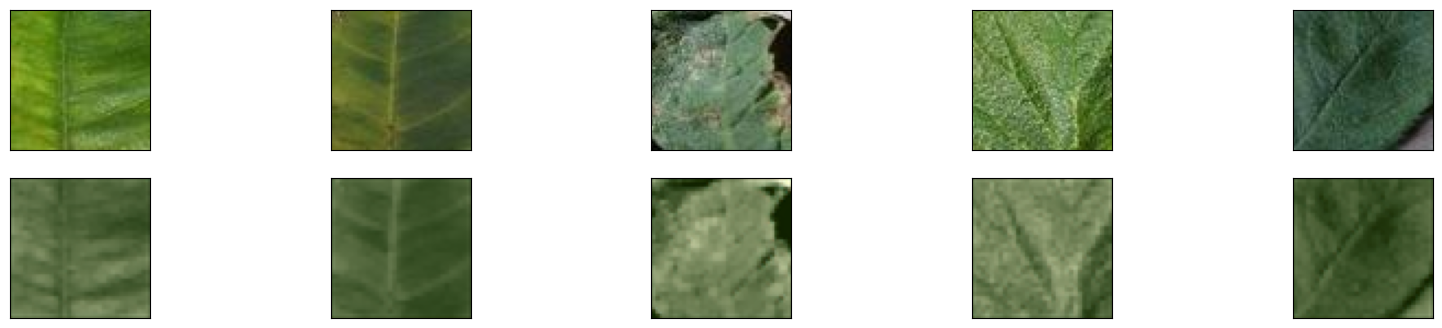

In [97]:
"""
-- Test image creation with autoencoder
"""

reconstructed_imgs = autoencoder.predict(X_test[:5])

print(mean_squared_error(X_test[0][0], reconstructed_imgs[0][0]))

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Clasificador B -> Pesos del autoencoder congelados

In [99]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoder.trainable = False 
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

129/129 [==============================] - 1s 8ms/step


In [151]:
"""
-- Analisis mejores hiperparámetros del clasificador --
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.03, log=True)
    epochs = trial.suggest_int('epochs', 250, 450)    

    print(f"Beggining trial with lr={lr} and epochs={epochs}")

    # Definir la arquitectura del clasificador utilizando el vector latente como entrada
    output = Flatten()(latent)
    output = Dense(128, activation='relu')(output)
    output = Dense(64, activation='relu')(output)
    output = Dense(38, activation='sigmoid')(output)

    # Crear el modelo del clasificador
    classifier = Model(latent, output)

    # Compilar el modelo del clasificador
    optimizer = Adam(learning_rate = lr)
    classifier.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

    # Entrenar el clasificador utilizando el vector latente como características de entrada
    classifier.fit(encoded_train, y_train,
                epochs=epochs,
                batch_size=256,
                verbose=0)

    # Evaluar el rendimiento del clasificador en el conjunto de prueba
    _, accuracy = classifier.evaluate(encoded_test, y_test, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-13 14:57:27,337] A new study created in memory with name: no-name-c5b8d4f4-9b2f-4045-8b9d-de5ab047fed2


Beggining trial with lr=0.0022373958781730457 and epochs=361


[I 2023-06-13 15:30:26,224] Trial 0 finished with value: 0.2787642776966095 and parameters: {'lr': 0.0022373958781730457, 'epochs': 361}. Best is trial 0 with value: 0.2787642776966095.


Beggining trial with lr=0.006562970366616648 and epochs=263


[I 2023-06-13 15:54:15,767] Trial 1 finished with value: 0.29506203532218933 and parameters: {'lr': 0.006562970366616648, 'epochs': 263}. Best is trial 1 with value: 0.29506203532218933.


Beggining trial with lr=0.0071067908269241255 and epochs=397


[I 2023-06-13 16:29:56,440] Trial 2 finished with value: 0.28144004940986633 and parameters: {'lr': 0.0071067908269241255, 'epochs': 397}. Best is trial 1 with value: 0.29506203532218933.


Beggining trial with lr=0.021369648862464546 and epochs=397


[I 2023-06-13 17:05:13,682] Trial 3 finished with value: 0.2816832959651947 and parameters: {'lr': 0.021369648862464546, 'epochs': 397}. Best is trial 1 with value: 0.29506203532218933.


Beggining trial with lr=0.006040940645104192 and epochs=388


[I 2023-06-13 17:39:06,742] Trial 4 finished with value: 0.2770615518093109 and parameters: {'lr': 0.006040940645104192, 'epochs': 388}. Best is trial 1 with value: 0.29506203532218933.


Beggining trial with lr=0.011054555482078874 and epochs=429


[I 2023-06-13 18:17:05,051] Trial 5 finished with value: 0.27365604043006897 and parameters: {'lr': 0.011054555482078874, 'epochs': 429}. Best is trial 1 with value: 0.29506203532218933.



Time taken to find best hyperparams: 11977.764578819275 s
Best Hyperparameters:  {'lr': 0.006562970366616648, 'epochs': 263}
Best Accuracy:  0.29506203532218933


In [153]:
"""
-- Entrenamiento del modelo con los mejores hiperparámetros --
"""
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
output = Flatten()(latent)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = best_params['lr'])
classifier.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=600,
               batch_size=256,
               verbose=1)


Epoch 1/600
91/91 [==============================] - 7s 52ms/step - loss: 0.0595 - accuracy: 0.0350
Epoch 2/600
91/91 [==============================] - 4s 47ms/step - loss: 0.0500 - accuracy: 0.0349
Epoch 3/600
91/91 [==============================] - 4s 44ms/step - loss: 0.0499 - accuracy: 0.0349
Epoch 4/600
91/91 [==============================] - 4s 44ms/step - loss: 0.0499 - accuracy: 0.0349
Epoch 5/600
91/91 [==============================] - 4s 45ms/step - loss: 0.0498 - accuracy: 0.0349
Epoch 6/600
91/91 [==============================] - 4s 46ms/step - loss: 0.0498 - accuracy: 0.0349
Epoch 7/600
91/91 [==============================] - 4s 44ms/step - loss: 0.0498 - accuracy: 0.0349
Epoch 8/600
91/91 [==============================] - 4s 44ms/step - loss: 0.0465 - accuracy: 0.0421
Epoch 9/600
91/91 [==============================] - 4s 43ms/step - loss: 0.0255 - accuracy: 0.1105
Epoch 10/600
91/91 [==============================] - 4s 42ms/step - loss: 0.0254 - accuracy: 0.1196

In [155]:
"""
-- Obtención de las métricas -- 
"""

predictions = classifier.predict(encoded_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)


129/129 [==============================] - 1s 4ms/step
Accuracy:  0.285332036000973
Precision:  [0.05263158 0.25       0.         0.25641026 0.26724138 0.04918033
 0.20754717 0.03125    0.28571429 0.125      0.4        0.2
 0.28571429 0.09090909 0.06060606 0.48006645 0.21428571 0.14285714
 0.12727273 0.11363636 0.15294118 0.03947368 0.93333333 0.16666667
 0.48022599 0.21518987 0.14285714 0.03846154 0.36936937 0.12765957
 0.1122449  0.28571429 0.09913793 0.18978102 0.09782609 0.40268456
 0.         0.46153846]
Recall:  [0.0212766  0.10869565 0.         0.16260163 0.27433628 0.03797468
 0.171875   0.02564103 0.26966292 0.2027027  0.4137931  0.17977528
 0.28846154 0.08641975 0.0625     0.69975787 0.24418605 0.11111111
 0.09333333 0.13513514 0.17333333 0.04       0.57142857 0.03571429
 0.44502618 0.36956522 0.07228916 0.02941176 0.25786164 0.08
 0.07692308 0.14084507 0.17293233 0.20634921 0.08571429 0.44776119
 0.         0.30252101]
F1 score:  [0.03030303 0.15151515 0.         0.19900498 

#### Clasificador C -> Pesos del autoencoder sin congelar

In [156]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoder.trainable = True 
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

129/129 [==============================] - 1s 8ms/step


In [187]:
"""
-- Analisis mejores hiperparámetros del clasificador --
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.0001, 0.03, log=True)

    print(f"Beggining trial with lr={lr} and epochs={50}")

    # Definir la arquitectura del clasificador utilizando el vector latente como entrada
    output = Flatten()(latent)
    output = Dense(128, activation='relu')(output)
    output = Dense(64, activation='relu')(output)
    output = Dense(38, activation='sigmoid')(output)

    # Crear el modelo del clasificador
    classifier = Model(latent, output)

    # Compilar el modelo del clasificador
    optimizer = Adam(learning_rate = lr)
    classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

    # Entrenar el clasificador utilizando el vector latente como características de entrada
    classifier.fit(encoded_train, y_train,
                epochs=50,
                batch_size=256,
                verbose=0)

    # Evaluar el rendimiento del clasificador en el conjunto de prueba
    _, accuracy = classifier.evaluate(encoded_test, y_test, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-14 08:28:50,888] A new study created in memory with name: no-name-a7d375e1-84cf-499b-bf9e-e71e8a563406


Beggining trial with lr=0.0006371914546883453 and epochs=50


[I 2023-06-14 08:32:14,766] Trial 0 finished with value: 0.3349146842956543 and parameters: {'lr': 0.0006371914546883453}. Best is trial 0 with value: 0.3349146842956543.


Beggining trial with lr=0.0010280451476726155 and epochs=50


[I 2023-06-14 08:35:37,555] Trial 1 finished with value: 0.33619195222854614 and parameters: {'lr': 0.0010280451476726155}. Best is trial 1 with value: 0.33619195222854614.


Beggining trial with lr=0.003036760224936215 and epochs=50


[I 2023-06-14 08:39:03,340] Trial 2 finished with value: 0.02326430007815361 and parameters: {'lr': 0.003036760224936215}. Best is trial 1 with value: 0.33619195222854614.


Beggining trial with lr=0.0002739983814349991 and epochs=50


[I 2023-06-14 08:41:48,937] Trial 3 finished with value: 0.2918073236942291 and parameters: {'lr': 0.0002739983814349991}. Best is trial 1 with value: 0.33619195222854614.


Beggining trial with lr=0.0018865105798247994 and epochs=50


[I 2023-06-14 08:45:09,974] Trial 4 finished with value: 0.3534805178642273 and parameters: {'lr': 0.0018865105798247994}. Best is trial 4 with value: 0.3534805178642273.


Beggining trial with lr=0.004343917034270179 and epochs=50


[I 2023-06-14 08:48:27,121] Trial 5 finished with value: 0.006523127667605877 and parameters: {'lr': 0.004343917034270179}. Best is trial 4 with value: 0.3534805178642273.


Beggining trial with lr=0.01582721539250536 and epochs=50


[I 2023-06-14 08:51:42,261] Trial 6 finished with value: 0.011495301499962807 and parameters: {'lr': 0.01582721539250536}. Best is trial 4 with value: 0.3534805178642273.


Beggining trial with lr=0.0002788235582077378 and epochs=50


[I 2023-06-14 08:54:49,151] Trial 7 finished with value: 0.3041236996650696 and parameters: {'lr': 0.0002788235582077378}. Best is trial 4 with value: 0.3534805178642273.


Beggining trial with lr=0.016822332989132917 and epochs=50


[I 2023-06-14 08:57:52,573] Trial 8 finished with value: 0.10049265623092651 and parameters: {'lr': 0.016822332989132917}. Best is trial 4 with value: 0.3534805178642273.


Beggining trial with lr=0.026797763657364825 and epochs=50


[I 2023-06-14 09:01:10,014] Trial 9 finished with value: 0.011495301499962807 and parameters: {'lr': 0.026797763657364825}. Best is trial 4 with value: 0.3534805178642273.


Beggining trial with lr=0.00010563754431215495 and epochs=50


[I 2023-06-14 09:04:25,449] Trial 10 finished with value: 0.2828209102153778 and parameters: {'lr': 0.00010563754431215495}. Best is trial 4 with value: 0.3534805178642273.


Beggining trial with lr=0.0013495990169687965 and epochs=50


[I 2023-06-14 09:07:40,192] Trial 11 finished with value: 0.35635435581207275 and parameters: {'lr': 0.0013495990169687965}. Best is trial 11 with value: 0.35635435581207275.


Beggining trial with lr=0.0019335572458180205 and epochs=50


[I 2023-06-14 09:10:52,291] Trial 12 finished with value: 0.3645196557044983 and parameters: {'lr': 0.0019335572458180205}. Best is trial 12 with value: 0.3645196557044983.


Beggining trial with lr=0.005996423619573412 and epochs=50


[I 2023-06-14 09:13:32,528] Trial 13 finished with value: 0.005519569385796785 and parameters: {'lr': 0.005996423619573412}. Best is trial 12 with value: 0.3645196557044983.


Beggining trial with lr=0.0014081855744098684 and epochs=50


[I 2023-06-14 09:16:21,885] Trial 14 finished with value: 0.34750479459762573 and parameters: {'lr': 0.0014081855744098684}. Best is trial 12 with value: 0.3645196557044983.



Time taken to find best hyperparams: 2851.0209505558014 s
Best Hyperparameters:  {'lr': 0.0019335572458180205}
Best Accuracy:  0.3645196557044983


In [190]:
"""
-- Entrenamiento del modelo con los mejores hiperparámetros --
"""
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
output = Flatten()(latent)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = best_params['lr'])
classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=700,
               batch_size=256,
               verbose=1)


Epoch 1/700
86/86 [==============================] - 4s 29ms/step - loss: 0.0322 - accuracy: 0.0960
Epoch 2/700
86/86 [==============================] - 2s 28ms/step - loss: 0.0253 - accuracy: 0.1174
Epoch 3/700
86/86 [==============================] - 2s 28ms/step - loss: 0.0254 - accuracy: 0.1190
Epoch 4/700
86/86 [==============================] - 2s 27ms/step - loss: 0.0254 - accuracy: 0.1165
Epoch 5/700
86/86 [==============================] - 2s 25ms/step - loss: 0.0253 - accuracy: 0.1181
Epoch 6/700
86/86 [==============================] - 2s 24ms/step - loss: 0.0252 - accuracy: 0.1229
Epoch 7/700
86/86 [==============================] - 2s 24ms/step - loss: 0.0251 - accuracy: 0.1253
Epoch 8/700
86/86 [==============================] - 2s 25ms/step - loss: 0.0251 - accuracy: 0.1243
Epoch 9/700
86/86 [==============================] - 2s 25ms/step - loss: 0.0251 - accuracy: 0.1262
Epoch 10/700
86/86 [==============================] - 2s 25ms/step - loss: 0.0252 - accuracy: 0.1260

In [192]:
"""
-- Obtención de las métricas -- 
"""

predictions = classifier.predict(encoded_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)


686/686 [==============================] - 4s 6ms/step
Accuracy:  0.47495666453790714
Precision:  [0.13013699 0.15151515 0.05       0.42007926 0.32165605 0.2402746
 0.39622642 0.12962963 0.50411523 0.29574861 0.57373737 0.22421525
 0.43086817 0.53005464 0.19313305 0.70866142 0.54435484 0.36538462
 0.14828897 0.27422481 0.42492918 0.19310345 0.85625    0.24770642
 0.73954829 0.41725352 0.51190476 0.29166667 0.57975035 0.10958904
 0.31584821 0.27529412 0.17339901 0.41845494 0.25986842 0.71079982
 0.29333333 0.38610039]
Recall:  [0.07539683 0.06048387 0.01818182 0.48328267 0.33610649 0.24940618
 0.43108504 0.03414634 0.51362683 0.40609137 0.61075269 0.21186441
 0.48462929 0.45011601 0.26627219 0.85792102 0.58759521 0.26388889
 0.09798995 0.47884941 0.375      0.14       0.52490421 0.18120805
 0.75589391 0.32288828 0.19413093 0.1147541  0.49118684 0.04
 0.37041885 0.30789474 0.24858757 0.29061103 0.28163993 0.73401773
 0.14765101 0.47095761]
F1 score:  [0.09547739 0.08645533 0.02666667 0.4

### Ejecución 2
Distribución de datos:
- 80% -> Datos sin labels para autoencoder
- 10% -> Datos con labels (training)
- 10% -> Datos con labels (testing)

#### Carga de datos 2

In [69]:
"""
-- Load data from analysis dataset --
"""

parent_folder_path = "images/resized_dataset/"

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(parent_folder_path))):
    folder_path = os.path.join(parent_folder_path, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images per category
category_amount = []
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

# get images 
arrays = []
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (64, 64):
            print(file_path, " IS NOT 64x64, it is: ", image.size)
            continue

        arrays.append(image_array)

# generate the labels array
arrays_labels = []
for i in range(len(categories)):
    arrays_labels += [i] * category_amount[i]
arrays_labels = np.array(arrays_labels)

In [70]:
"""
-- Load autoencoder, train and testing data --

Using the distribution:
80% -> autoencoder
10% -> training data
10% -> testing data
"""

X_auto, X, y_auto, y = train_test_split(arrays, arrays_labels, test_size=0.8, random_state=42, stratify=arrays_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# normalize 
X_auto = np.array(X_auto).astype('float32') / 255
X_train = np.array(X_train).astype('float32') / 255
X_test = np.array(X_test).astype('float32') / 255
X = np.array(X).astype('float32') / 255

# resize 
X_auto = X_auto.reshape((len(X_auto), 64, 64, 3))
X_train = X_train.reshape((len(X_train), 64, 64, 3))
X_test = X_test.reshape((len(X_test), 64, 64, 3))
X = X.reshape((len(X), 64, 64, 3))

# make labels as lists with possible values
y_train = to_categorical(y_train, num_classes=38)
y_test = to_categorical(y_test, num_classes=38)
y = to_categorical(y, num_classes=38)


#### Clasificador D -> Sin autoencoder

In [73]:
"""
-- No autoencoder, calculated with CNN --

Get the best hyperparameters for the CNN architecture proposed
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.2, log=True)
    epochs = trial.suggest_int('epochs', 5, 25)    

    print(f"Beggining trial with lr={lr} and epochs={epochs}")

    model_cnn = Sequential()
    model_cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(64, activation='relu'))
    model_cnn.add(Dense(38, activation='softmax'))

    # compile the model
    optimizer = Adam(learning_rate=lr)
    model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Trian the model
    model_cnn.fit(X_train, y_train, 
                batch_size=256, 
                epochs=epochs, 
                verbose=0)
    
    # Evaluate the autoencoder
    _, accuracy = model_cnn.evaluate(X_test, y_test, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-14 16:06:28,416] A new study created in memory with name: no-name-c2a80596-fbf5-43a0-ba45-8d3b57e0aa5c


Beggining trial with lr=0.09418594509299022 and epochs=21


[I 2023-06-14 16:09:29,090] Trial 0 finished with value: 0.10049265623092651 and parameters: {'lr': 0.09418594509299022, 'epochs': 21}. Best is trial 0 with value: 0.10049265623092651.


Beggining trial with lr=0.03166810268657376 and epochs=13


[I 2023-06-14 16:11:20,650] Trial 1 finished with value: 0.09775567799806595 and parameters: {'lr': 0.03166810268657376, 'epochs': 13}. Best is trial 0 with value: 0.10049265623092651.


Beggining trial with lr=0.0036717505322774804 and epochs=20


[I 2023-06-14 16:14:14,518] Trial 2 finished with value: 0.5975276231765747 and parameters: {'lr': 0.0036717505322774804, 'epochs': 20}. Best is trial 2 with value: 0.5975276231765747.


Beggining trial with lr=0.1453641510782445 and epochs=5


[I 2023-06-14 16:14:59,315] Trial 3 finished with value: 0.09287473559379578 and parameters: {'lr': 0.1453641510782445, 'epochs': 5}. Best is trial 2 with value: 0.5975276231765747.


Beggining trial with lr=0.004110702435719256 and epochs=15


[I 2023-06-14 16:17:09,010] Trial 4 finished with value: 0.5765441060066223 and parameters: {'lr': 0.004110702435719256, 'epochs': 15}. Best is trial 2 with value: 0.5975276231765747.


Beggining trial with lr=0.1343755230683487 and epochs=8


[I 2023-06-14 16:18:19,456] Trial 5 finished with value: 0.09287473559379578 and parameters: {'lr': 0.1343755230683487, 'epochs': 8}. Best is trial 2 with value: 0.5975276231765747.


Beggining trial with lr=0.1010139128272509 and epochs=10


[I 2023-06-14 16:19:47,522] Trial 6 finished with value: 0.09775567799806595 and parameters: {'lr': 0.1010139128272509, 'epochs': 10}. Best is trial 2 with value: 0.5975276231765747.


Beggining trial with lr=0.02876241044489664 and epochs=7


[I 2023-06-14 16:20:48,237] Trial 7 finished with value: 0.10049265623092651 and parameters: {'lr': 0.02876241044489664, 'epochs': 7}. Best is trial 2 with value: 0.5975276231765747.


Beggining trial with lr=0.0020298030179754785 and epochs=23


[I 2023-06-14 16:24:02,649] Trial 8 finished with value: 0.5836146473884583 and parameters: {'lr': 0.0020298030179754785, 'epochs': 23}. Best is trial 2 with value: 0.5975276231765747.


Beggining trial with lr=0.005084120069759247 and epochs=21


[I 2023-06-14 16:27:01,005] Trial 9 finished with value: 0.5078459978103638 and parameters: {'lr': 0.005084120069759247, 'epochs': 21}. Best is trial 2 with value: 0.5975276231765747.



Time taken to find best hyperparams: 1232.5900526046753 s
Best Hyperparameters:  {'lr': 0.0036717505322774804, 'epochs': 20}
Best Accuracy:  0.5975276231765747


In [74]:
"""
-- Create CCNN with no autoencoder --
"""
model_cnn = Sequential()
model_cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(38, activation='softmax'))

# compile the model
optimizer = Adam(learning_rate=best_params['lr'])
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Trian the model
model_cnn.fit(X_train, y_train, 
              batch_size=256, 
              epochs=best_params['epochs'], 
              verbose=1)

Epoch 1/20
86/86 [==============================] - 9s 99ms/step - loss: 2.9721 - accuracy: 0.2462
Epoch 2/20
86/86 [==============================] - 8s 98ms/step - loss: 2.1384 - accuracy: 0.3971
Epoch 3/20
86/86 [==============================] - 8s 97ms/step - loss: 1.7777 - accuracy: 0.4875
Epoch 4/20
86/86 [==============================] - 8s 97ms/step - loss: 1.5776 - accuracy: 0.5405
Epoch 5/20
86/86 [==============================] - 8s 97ms/step - loss: 1.3715 - accuracy: 0.5977
Epoch 6/20
86/86 [==============================] - 8s 97ms/step - loss: 1.2260 - accuracy: 0.6407
Epoch 7/20
86/86 [==============================] - 8s 97ms/step - loss: 1.1294 - accuracy: 0.6657
Epoch 8/20
86/86 [==============================] - 8s 98ms/step - loss: 0.9789 - accuracy: 0.7090
Epoch 9/20
86/86 [==============================] - 8s 97ms/step - loss: 0.8822 - accuracy: 0.7362
Epoch 10/20
86/86 [==============================] - 8s 98ms/step - loss: 0.7822 - accuracy: 0.7703
Epoch 11/

In [77]:
model_cnn.evaluate(X_test, y_test)

686/686 [==============================] - 4s 6ms/step - loss: 2.1025 - accuracy: 0.5796


[2.1025452613830566, 0.5795547962188721]

In [78]:
"""
-- Obtención de las métricas para CNN sin autoencoder -- 
"""

predictions = model_cnn.predict(X_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy:\n ", accuracy_score(real_values, predictions))
print("Precision:\n ", precision_score(real_values, predictions, average=None))
print("Recall:\n ", recall_score(real_values, predictions, average=None))
print("F1 score:\n ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:\n", auc)

686/686 [==============================] - 4s 6ms/step
Accuracy:
  0.5795547851473406
Precision:
  [0.18627451 0.33526012 0.16       0.47959184 0.33333333 0.52986513
 0.50783699 0.40825688 0.58682635 0.67279412 0.66875    0.46173469
 0.59904913 0.66451613 0.50684932 0.92809204 0.63106796 0.42331288
 0.28145695 0.57359307 0.47961631 0.28919861 0.81355932 0.39495798
 0.69507428 0.62916006 0.44978166 0.32231405 0.6754386  0.20604396
 0.30769231 0.45701357 0.28275862 0.52315609 0.39279588 0.74839228
 0.4140625  0.72495088]
Recall:
  [0.15079365 0.23387097 0.10909091 0.42857143 0.54242928 0.65320665
 0.47507331 0.43414634 0.6163522  0.46446701 0.69032258 0.38347458
 0.6835443  0.47795824 0.21893491 0.87880163 0.63656148 0.47916667
 0.21356784 0.44839255 0.5        0.2075     0.55172414 0.31543624
 0.87328094 0.54087193 0.46501129 0.21311475 0.54289072 0.1875
 0.48167539 0.26578947 0.28954802 0.45454545 0.40819964 0.86887541
 0.3557047  0.57927786]
F1 score:
  [0.16666667 0.27553444 0.129729

#### Autoencoder

In [174]:
"""
-- Autoencoder calculated with CNN --

Get the best hyperparameters for the autoencoder using the CNN architecture proposed
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.05, log=True)
    epochs = trial.suggest_int('epochs', 5, 25)    

    print(f"Beggining trial with lr={lr} and epochs={epochs}")

    input_img = Input(shape=X_auto[0].shape)
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    latent = MaxPooling2D((2, 2), padding='same')(encoded)
    decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(latent)
    decoded = UpSampling2D((2,2))(decoded)
    decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(decoded)

    autoencoder = Model(input_img, decoded)

    # Compile the autoencoder
    optimizer = Adam(learning_rate = lr)
    autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

    # Train the autoencoder
    autoencoder.fit(X_auto, X_auto,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    verbose=0)
    
    # Evaluate the autoencoder
    _, accuracy = autoencoder.evaluate(X_auto, X_auto, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-13 21:12:51,473] A new study created in memory with name: no-name-eb9c528c-0853-457a-b08b-69ff974621ae


Beggining trial with lr=0.020145077149115266 and epochs=12


[I 2023-06-13 21:18:59,819] Trial 0 finished with value: 0.889375627040863 and parameters: {'lr': 0.020145077149115266, 'epochs': 12}. Best is trial 0 with value: 0.889375627040863.


Beggining trial with lr=0.003172397517071078 and epochs=10


[I 2023-06-13 21:24:09,642] Trial 1 finished with value: 0.9646710753440857 and parameters: {'lr': 0.003172397517071078, 'epochs': 10}. Best is trial 1 with value: 0.9646710753440857.


Beggining trial with lr=0.030807834697157324 and epochs=6


[I 2023-06-13 21:27:18,213] Trial 2 finished with value: 0.0998847484588623 and parameters: {'lr': 0.030807834697157324, 'epochs': 6}. Best is trial 1 with value: 0.9646710753440857.


Beggining trial with lr=0.025063342883544105 and epochs=13


[I 2023-06-13 21:33:59,639] Trial 3 finished with value: 0.8873006105422974 and parameters: {'lr': 0.025063342883544105, 'epochs': 13}. Best is trial 1 with value: 0.9646710753440857.


Beggining trial with lr=0.029400238862220544 and epochs=7


[I 2023-06-13 21:37:40,395] Trial 4 finished with value: 0.8897082209587097 and parameters: {'lr': 0.029400238862220544, 'epochs': 7}. Best is trial 1 with value: 0.9646710753440857.


Beggining trial with lr=0.021045921595504002 and epochs=15


[I 2023-06-13 21:46:04,290] Trial 5 finished with value: 0.8897082209587097 and parameters: {'lr': 0.021045921595504002, 'epochs': 15}. Best is trial 1 with value: 0.9646710753440857.


Beggining trial with lr=0.016635883437565863 and epochs=17


[I 2023-06-13 21:55:40,872] Trial 6 finished with value: 0.890261173248291 and parameters: {'lr': 0.016635883437565863, 'epochs': 17}. Best is trial 1 with value: 0.9646710753440857.


Beggining trial with lr=0.024975270778904646 and epochs=21


[I 2023-06-13 22:07:31,844] Trial 7 finished with value: 0.8897082209587097 and parameters: {'lr': 0.024975270778904646, 'epochs': 21}. Best is trial 1 with value: 0.9646710753440857.


Beggining trial with lr=0.007570478633771499 and epochs=20


[I 2023-06-13 22:18:19,123] Trial 8 finished with value: 0.9649211764335632 and parameters: {'lr': 0.007570478633771499, 'epochs': 20}. Best is trial 8 with value: 0.9649211764335632.


Beggining trial with lr=0.0014139142876124517 and epochs=13


[I 2023-06-13 22:25:29,134] Trial 9 finished with value: 0.9639644026756287 and parameters: {'lr': 0.0014139142876124517, 'epochs': 13}. Best is trial 8 with value: 0.9649211764335632.



Time taken to find best hyperparams: 4357.744573831558 s
Best Hyperparameters:  {'lr': 0.007570478633771499, 'epochs': 20}
Best Accuracy:  0.9649211764335632


In [175]:
"""
-- Create autoencoder --
"""
input_img = Input(shape=X_auto[0].shape)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
latent = MaxPooling2D((2, 2), padding='same')(encoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(latent)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

# Compile the autoencoder
optimizer = Adam(learning_rate = best_params['lr'])
autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Train the autoencoder
autoencoder.fit(X_auto, X_auto,
                epochs=best_params['epochs'],
                batch_size=256,
                shuffle=True,
                verbose=1)

Epoch 1/20
43/43 [==============================] - 34s 758ms/step - loss: 0.0246 - accuracy: 0.6878
Epoch 2/20
43/43 [==============================] - 33s 764ms/step - loss: 0.0066 - accuracy: 0.8891
Epoch 3/20
43/43 [==============================] - 32s 751ms/step - loss: 0.0042 - accuracy: 0.8865
Epoch 4/20
43/43 [==============================] - 38s 878ms/step - loss: 0.0035 - accuracy: 0.8862
Epoch 5/20
43/43 [==============================] - 37s 872ms/step - loss: 0.0032 - accuracy: 0.8879
Epoch 6/20
43/43 [==============================] - 34s 787ms/step - loss: 0.0031 - accuracy: 0.8886
Epoch 7/20
43/43 [==============================] - 32s 753ms/step - loss: 0.0030 - accuracy: 0.8887
Epoch 8/20
43/43 [==============================] - 33s 776ms/step - loss: 0.0029 - accuracy: 0.8889
Epoch 9/20
43/43 [==============================] - 34s 790ms/step - loss: 0.0029 - accuracy: 0.8889
Epoch 10/20
43/43 [==============================] - 33s 755ms/step - loss: 0.0036 - accura

In [176]:
autoencoder.evaluate(X_test, X_test)

686/686 [==============================] - 13s 18ms/step - loss: 0.0026 - accuracy: 0.8896


[0.002587489318102598, 0.8896285891532898]

1/1 [==============================] - 0s 136ms/step
0.0016222676


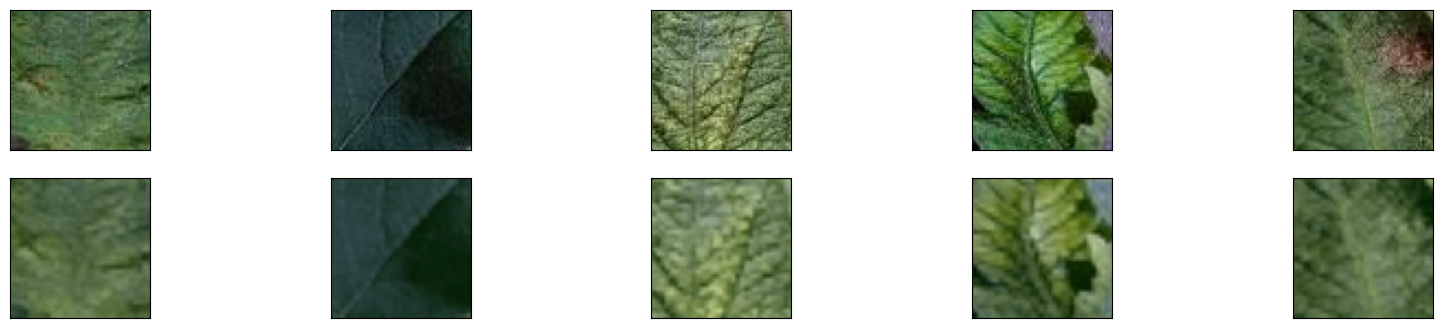

In [177]:
"""
-- Test image creation with autoencoder
"""

reconstructed_imgs = autoencoder.predict(X_test[:5])

print(mean_squared_error(X_test[0][0], reconstructed_imgs[0][0]))

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Clasificador E

In [178]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoder.trainable = False 
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

686/686 [==============================] - 6s 8ms/step


In [179]:
"""
-- Analisis mejores hiperparámetros del clasificador --
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.03, log=True)

    print(f"Beggining trial with lr={lr} and epochs={50}")

    # Definir la arquitectura del clasificador utilizando el vector latente como entrada
    output = Flatten()(latent)
    output = Dense(128, activation='relu')(output)
    output = Dense(64, activation='relu')(output)
    output = Dense(38, activation='sigmoid')(output)

    # Crear el modelo del clasificador
    classifier = Model(latent, output)

    # Compilar el modelo del clasificador
    optimizer = Adam(learning_rate = lr)
    classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

    # Entrenar el clasificador utilizando el vector latente como características de entrada
    classifier.fit(encoded_train, y_train,
                epochs=50,
                batch_size=256,
                verbose=0)

    # Evaluar el rendimiento del clasificador en el conjunto de prueba
    _, accuracy = classifier.evaluate(encoded_test, y_test, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-13 22:36:43,567] A new study created in memory with name: no-name-b0739989-c328-4989-b971-7c9571ab4253


Beggining trial with lr=0.004509100791452501 and epochs=50


[I 2023-06-13 22:40:20,183] Trial 0 finished with value: 0.018200894817709923 and parameters: {'lr': 0.004509100791452501}. Best is trial 0 with value: 0.018200894817709923.


Beggining trial with lr=0.002937163626551822 and epochs=50


[I 2023-06-13 22:44:16,016] Trial 1 finished with value: 0.023355532437562943 and parameters: {'lr': 0.002937163626551822}. Best is trial 1 with value: 0.023355532437562943.


Beggining trial with lr=0.00371979955875617 and epochs=50


[I 2023-06-13 22:47:24,273] Trial 2 finished with value: 0.005200255662202835 and parameters: {'lr': 0.00371979955875617}. Best is trial 1 with value: 0.023355532437562943.


Beggining trial with lr=0.004075680594170305 and epochs=50


[I 2023-06-13 22:50:53,907] Trial 3 finished with value: 0.010719824582338333 and parameters: {'lr': 0.004075680594170305}. Best is trial 1 with value: 0.023355532437562943.


Beggining trial with lr=0.0015440754561245843 and epochs=50


[I 2023-06-13 22:54:29,529] Trial 4 finished with value: 0.3163032531738281 and parameters: {'lr': 0.0015440754561245843}. Best is trial 4 with value: 0.3163032531738281.


Beggining trial with lr=0.002878414434773279 and epochs=50


[I 2023-06-13 22:58:10,652] Trial 5 finished with value: 0.09775567799806595 and parameters: {'lr': 0.002878414434773279}. Best is trial 4 with value: 0.3163032531738281.



Time taken to find best hyperparams: 1287.143387079239 s
Best Hyperparameters:  {'lr': 0.0015440754561245843}
Best Accuracy:  0.3163032531738281


In [180]:
"""
-- Entrenamiento del modelo con los mejores hiperparámetros --
"""
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
output = Flatten()(latent)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = best_params['lr'])
classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=600,
               batch_size=256,
               verbose=1)


Epoch 1/600
86/86 [==============================] - 3s 31ms/step - loss: 0.0479 - accuracy: 0.0723
Epoch 2/600
86/86 [==============================] - 3s 31ms/step - loss: 0.0252 - accuracy: 0.1604
Epoch 3/600
86/86 [==============================] - 3s 29ms/step - loss: 0.0252 - accuracy: 0.1218
Epoch 4/600
86/86 [==============================] - 2s 28ms/step - loss: 0.0253 - accuracy: 0.1216
Epoch 5/600
86/86 [==============================] - 3s 29ms/step - loss: 0.0251 - accuracy: 0.1240
Epoch 6/600
86/86 [==============================] - 2s 29ms/step - loss: 0.0249 - accuracy: 0.1543
Epoch 7/600
86/86 [==============================] - 2s 28ms/step - loss: 0.0245 - accuracy: 0.1833
Epoch 8/600
86/86 [==============================] - 2s 28ms/step - loss: 0.0245 - accuracy: 0.1861
Epoch 9/600
86/86 [==============================] - 2s 27ms/step - loss: 0.0243 - accuracy: 0.1889
Epoch 10/600
86/86 [==============================] - 2s 28ms/step - loss: 0.0242 - accuracy: 0.1899

In [181]:
"""
-- Obtención de las métricas -- 
"""

predictions = classifier.predict(encoded_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)


686/686 [==============================] - 4s 6ms/step
Accuracy:  0.4617279445306085
Precision:  [0.13131313 0.15337423 0.05208333 0.36226034 0.35687023 0.27804878
 0.51079137 0.06910569 0.         0.26067747 0.375      0.23153693
 0.48747153 0.41818182 0.1557377  0.68772305 0.58877551 0.4180791
 0.15744681 0.30539773 0.         0.12677878 0.67407407 0.30985915
 0.68236715 0.31043478 0.3875502  0.28205128 0.57160804 0.11290323
 0.32625698 0.37278107 0.28601695 0.32682927 0.24963716 0.70072661
 0.23076923 0.38422392]
Recall:  [0.0515873  0.10080645 0.04545455 0.54559271 0.31114809 0.13539192
 0.41642229 0.08292683 0.         0.44923858 0.00645161 0.24576271
 0.38698011 0.42691415 0.22485207 0.8747163  0.62785637 0.51388889
 0.09296482 0.36379019 0.         0.245      0.69731801 0.14765101
 0.83251473 0.48637602 0.43566591 0.12021858 0.5346651  0.035
 0.38219895 0.16578947 0.19067797 0.29955291 0.30659537 0.72001867
 0.06040268 0.47409733]
F1 score:  [0.07407407 0.1216545  0.04854369 0.4

c:\Users\Juan Navarro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


General AUC: 0.7235900255697719


#### Clasificador F

In [182]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoder.trainable = True 
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

686/686 [==============================] - 6s 9ms/step


In [193]:
"""
-- Analisis mejores hiperparámetros del clasificador --
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.0001, 0.03, log=True)

    print(f"Beggining trial with lr={lr} and epochs={50}")

    # Definir la arquitectura del clasificador utilizando el vector latente como entrada
    output = Flatten()(latent)
    output = Dense(128, activation='relu')(output)
    output = Dense(64, activation='relu')(output)
    output = Dense(38, activation='sigmoid')(output)

    # Crear el modelo del clasificador
    classifier = Model(latent, output)

    # Compilar el modelo del clasificador
    optimizer = Adam(learning_rate = lr)
    classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

    # Entrenar el clasificador utilizando el vector latente como características de entrada
    classifier.fit(encoded_train, y_train,
                epochs=50,
                batch_size=256,
                verbose=0)

    # Evaluar el rendimiento del clasificador en el conjunto de prueba
    _, accuracy = classifier.evaluate(encoded_test, y_test, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-14 10:14:10,023] A new study created in memory with name: no-name-ee0e2b7a-be2e-4e3d-942a-450e45aac0bf


Beggining trial with lr=0.009375837584906888 and epochs=50


[I 2023-06-14 10:15:58,940] Trial 0 finished with value: 0.011267220601439476 and parameters: {'lr': 0.009375837584906888}. Best is trial 0 with value: 0.011267220601439476.


Beggining trial with lr=0.0010979749102898075 and epochs=50


[I 2023-06-14 10:18:47,642] Trial 1 finished with value: 0.3284371793270111 and parameters: {'lr': 0.0010979749102898075}. Best is trial 1 with value: 0.3284371793270111.


Beggining trial with lr=0.010097921410978202 and epochs=50


[I 2023-06-14 10:21:30,416] Trial 2 finished with value: 0.09775567799806595 and parameters: {'lr': 0.010097921410978202}. Best is trial 1 with value: 0.3284371793270111.


Beggining trial with lr=0.0010376766910179258 and epochs=50


[I 2023-06-14 10:23:47,654] Trial 3 finished with value: 0.38071343302726746 and parameters: {'lr': 0.0010376766910179258}. Best is trial 3 with value: 0.38071343302726746.


Beggining trial with lr=0.00010077640049126614 and epochs=50


[I 2023-06-14 10:26:38,397] Trial 4 finished with value: 0.2551318407058716 and parameters: {'lr': 0.00010077640049126614}. Best is trial 3 with value: 0.38071343302726746.


Beggining trial with lr=0.02351310142347728 and epochs=50


[I 2023-06-14 10:29:07,927] Trial 5 finished with value: 0.011495301499962807 and parameters: {'lr': 0.02351310142347728}. Best is trial 3 with value: 0.38071343302726746.


Beggining trial with lr=0.0001969110661412261 and epochs=50


[I 2023-06-14 10:31:45,039] Trial 6 finished with value: 0.30453425645828247 and parameters: {'lr': 0.0001969110661412261}. Best is trial 3 with value: 0.38071343302726746.


Beggining trial with lr=0.02766026817268615 and epochs=50


[I 2023-06-14 10:34:55,669] Trial 7 finished with value: 0.011495301499962807 and parameters: {'lr': 0.02766026817268615}. Best is trial 3 with value: 0.38071343302726746.


Beggining trial with lr=0.020664179158769704 and epochs=50


[I 2023-06-14 10:38:05,139] Trial 8 finished with value: 0.011495301499962807 and parameters: {'lr': 0.020664179158769704}. Best is trial 3 with value: 0.38071343302726746.


Beggining trial with lr=0.009047312987403654 and epochs=50


[I 2023-06-14 10:40:52,081] Trial 9 finished with value: 0.030015509575605392 and parameters: {'lr': 0.009047312987403654}. Best is trial 3 with value: 0.38071343302726746.



Time taken to find best hyperparams: 1602.0933129787445 s
Best Hyperparameters:  {'lr': 0.0010376766910179258}
Best Accuracy:  0.38071343302726746


In [194]:
"""
-- Entrenamiento del modelo con los mejores hiperparámetros --
"""
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
output = Flatten()(latent)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = best_params['lr'])
classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=600,
               batch_size=256,
               verbose=1)


Epoch 1/600
86/86 [==============================] - 3s 25ms/step - loss: 0.0422 - accuracy: 0.0546
Epoch 2/600
86/86 [==============================] - 2s 25ms/step - loss: 0.0261 - accuracy: 0.0370
Epoch 3/600
86/86 [==============================] - 2s 25ms/step - loss: 0.0261 - accuracy: 0.0382
Epoch 4/600
86/86 [==============================] - 3s 35ms/step - loss: 0.0259 - accuracy: 0.0647
Epoch 5/600
86/86 [==============================] - 4s 46ms/step - loss: 0.0253 - accuracy: 0.1185
Epoch 6/600
86/86 [==============================] - 4s 45ms/step - loss: 0.0245 - accuracy: 0.1408
Epoch 7/600
86/86 [==============================] - 4s 47ms/step - loss: 0.0243 - accuracy: 0.1510
Epoch 8/600
86/86 [==============================] - 4s 44ms/step - loss: 0.0242 - accuracy: 0.1649
Epoch 9/600
86/86 [==============================] - 4s 45ms/step - loss: 0.0236 - accuracy: 0.2170
Epoch 10/600
86/86 [==============================] - 3s 39ms/step - loss: 0.0235 - accuracy: 0.2219

In [195]:
"""
-- Obtención de las métricas -- 
"""

predictions = classifier.predict(encoded_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)


686/686 [==============================] - 3s 4ms/step
Accuracy:  0.47363379253717725
Precision:  [0.09090909 0.23357664 0.02531646 0.43948127 0.32935917 0.23899371
 0.45552561 0.12820513 0.         0.29519071 0.41453567 0.24940048
 0.42439863 0.52108434 0.17826087 0.72367438 0.60206422 0.45384615
 0.29752066 0.45454545 0.         0.16761364 0.80092593 0.23333333
 0.7072227  0.24301279 0.34458259 0.19565217 0.53962264 0.185
 0.39055118 0.34074074 0.2544     0.36761905 0.31754875 0.71216216
 0.3        0.43531469]
Recall:  [0.11507937 0.12903226 0.01818182 0.46352584 0.36772047 0.18052257
 0.49560117 0.14634146 0.         0.45177665 0.66236559 0.22033898
 0.44665461 0.40139211 0.24260355 0.87970949 0.57127312 0.40972222
 0.09045226 0.27918782 0.         0.1475     0.66283525 0.09395973
 0.80795678 0.69891008 0.43792325 0.14754098 0.50411281 0.0925
 0.32460733 0.24210526 0.22457627 0.2876304  0.20320856 0.73775082
 0.12080537 0.39089482]
F1 score:  [0.10157618 0.16623377 0.02116402 0.451

c:\Users\Juan Navarro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


General AUC: 0.7297038394109829


## Experimento 2

In [ ]:
parent_folder_path = "Imagenes/resized_dataset/"

categories = {}

# Iterate over the contents of the "original_dataset" folder
for index, folder_name in enumerate(sorted(os.listdir(parent_folder_path))):
    folder_path = os.path.join(parent_folder_path, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

category_amount = []

# get the category with the least images
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

# get images 
arrays = []
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (64, 64):
            print(file_path, " IS NOT 64x64, it is: ", image.size)
            continue

        arrays.append(image_array)

# generate the labels array
arrays_labels = []
for i in range(len(categories)):
    arrays_labels += [i] * category_amount[i]
arrays_labels = np.array(arrays_labels)

In [198]:
"""
-- Load autoencoder, train and testing data --

Using the distribution:
80% -> autoencoder
10% -> training data
10% -> testing data
"""

X_auto, X, y_auto, y = train_test_split(arrays, arrays_labels, test_size=0.8, random_state=42, stratify=arrays_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# normalize 
X_auto = np.array(X_auto).astype('float32') / 255
X_train = np.array(X_train).astype('float32') / 255
X_test = np.array(X_test).astype('float32') / 255
X = np.array(X).astype('float32') / 255

# resize 
X_auto = X_auto.reshape((len(X_auto), 64, 64, 3))
X_train = X_train.reshape((len(X_train), 64, 64, 3))
X_test = X_test.reshape((len(X_test), 64, 64, 3))
X = X.reshape((len(X), 64, 64, 3))

# make labels as lists with possible values
y_train = to_categorical(y_train, num_classes=38)
y_test = to_categorical(y_test, num_classes=38)
y = to_categorical(y, num_classes=38)


X_auto_noise = np.zeros_like(X_auto)
for i in range(X_auto.shape[0]):
    X_auto_noise[i] = random_noise(X_auto[i], mode='s&p', amount=0.05, salt_vs_pepper=0.5)

X_train_noise = np.zeros_like(X_train)
for i in range(X_train.shape[0]):
    X_train_noise[i] = random_noise(X_train[i], mode='s&p', amount=0.05, salt_vs_pepper=0.5)

In [199]:
input_img = Input(shape=X_auto_noise[0].shape)
# Encoder
encoded = Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
encoded = MaxPooling2D((2, 2), padding="same")(encoded)
encoded = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
latent = MaxPooling2D((2, 2), padding="same")(encoded)

# Decoder
decoded = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(latent)
decoded = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(decoded)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(decoded)

autoencoder = Model(input_img, decoded)


In [200]:
optimizer = Adam(learning_rate = 0.019417802984540277)
autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Train the autoencoder
autoencoder.fit(x = X_auto_noise, y = X_auto,
                epochs=8,
                batch_size=256,
                shuffle=True,    
                verbose=1)

Epoch 1/8
43/43 [==============================] - 31s 696ms/step - loss: 0.0215 - accuracy: 0.8491
Epoch 2/8
43/43 [==============================] - 30s 691ms/step - loss: 0.0094 - accuracy: 0.8897
Epoch 3/8
43/43 [==============================] - 29s 674ms/step - loss: 0.0068 - accuracy: 0.8854
Epoch 4/8
43/43 [==============================] - 30s 694ms/step - loss: 0.0053 - accuracy: 0.8886
Epoch 5/8
43/43 [==============================] - 29s 677ms/step - loss: 0.0049 - accuracy: 0.8877
Epoch 6/8
43/43 [==============================] - 29s 684ms/step - loss: 0.0051 - accuracy: 0.8881
Epoch 7/8
43/43 [==============================] - 29s 676ms/step - loss: 0.0042 - accuracy: 0.8888
Epoch 8/8
43/43 [==============================] - 28s 659ms/step - loss: 0.0042 - accuracy: 0.8880


1/1 [==============================] - 0s 204ms/step


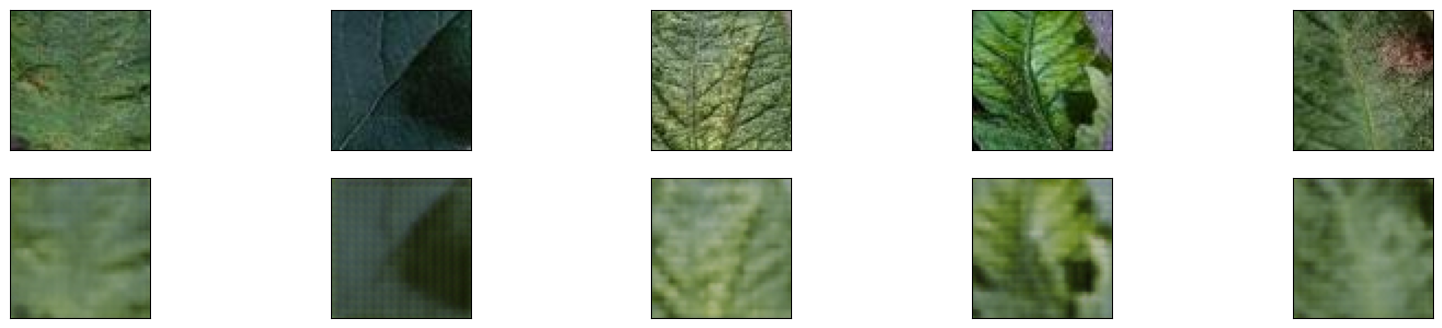

In [201]:
"""
-- Test image creation with autoencoder
"""

reconstructed_imgs = autoencoder.predict(X_test[:5])

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [202]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)
encoded_no_labels = encoder.predict(X_auto)

343/343 [==============================] - 4s 11ms/step


In [203]:
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
input_latent = Input(shape=encoded_train[0].shape)
output = Flatten()(input_latent)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(input_latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = 0.0005)
classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=700,
               batch_size=128,
               verbose=1,
               validation_data=(encoded_test, y_test))

Epoch 1/700
172/172 [==============================] - 3s 11ms/step - loss: 0.0368 - accuracy: 0.1649 - val_loss: 0.0227 - val_accuracy: 0.2579
Epoch 2/700
172/172 [==============================] - 2s 9ms/step - loss: 0.0222 - accuracy: 0.2785 - val_loss: 0.0218 - val_accuracy: 0.3035
Epoch 3/700
172/172 [==============================] - 2s 10ms/step - loss: 0.0216 - accuracy: 0.3078 - val_loss: 0.0213 - val_accuracy: 0.3185
Epoch 4/700
172/172 [==============================] - 2s 9ms/step - loss: 0.0212 - accuracy: 0.3271 - val_loss: 0.0211 - val_accuracy: 0.3213
Epoch 5/700
172/172 [==============================] - 2s 10ms/step - loss: 0.0209 - accuracy: 0.3404 - val_loss: 0.0208 - val_accuracy: 0.3357
Epoch 6/700
172/172 [==============================] - 2s 9ms/step - loss: 0.0206 - accuracy: 0.3483 - val_loss: 0.0206 - val_accuracy: 0.3544
Epoch 7/700
172/172 [==============================] - 2s 9ms/step - loss: 0.0204 - accuracy: 0.3606 - val_loss: 0.0206 - val_accuracy: 0.3

In [204]:
predictions = classifier.predict(encoded_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

686/686 [==============================] - 2s 3ms/step


In [207]:
# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])
for i in range(len(real_values)):
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)

Accuracy:  0.4950734422041784
Precision:  [0.13138686 0.325      0.11688312 0.47503566 0.40057225 0.21386139
 0.47735192 0.2300885  0.42295597 0.34285714 0.63471503 0.27489177
 0.43142857 0.40748899 0.24242424 0.80826915 0.48857143 0.3740458
 0.23076923 0.33395872 0.4        0.18384401 0.69166667 0.30851064
 0.70127026 0.43557583 0.36724566 0.15322581 0.57673267 0.14984709
 0.35934664 0.230563   0.19069767 0.36044881 0.29817444 0.75012107
 0.20338983 0.59885932]
Recall:  [0.14285714 0.10483871 0.08181818 0.50607903 0.46589018 0.25653207
 0.40175953 0.12682927 0.5639413  0.27411168 0.52688172 0.2690678
 0.54611212 0.42923434 0.33136095 0.90512937 0.55821545 0.34027778
 0.16582915 0.30118443 0.38       0.165      0.63601533 0.19463087
 0.78634578 0.52043597 0.33408578 0.10382514 0.54759107 0.1225
 0.2591623  0.22631579 0.23163842 0.38301043 0.26203209 0.72281848
 0.08053691 0.49450549]
F1 score:  [0.13688213 0.15853659 0.09625668 0.49006623 0.43076923 0.23326134
 0.43630573 0.16352201 0.

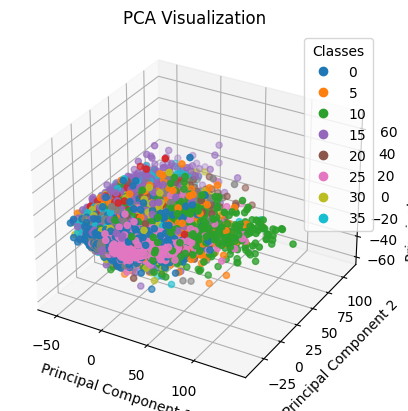

In [210]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_no_labels.reshape(10960,4096))

# Aplicar PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Guardar los resultados de PCA en TensorBoard
writer = SummaryWriter()
writer.add_embedding(X_pca, metadata=y_auto)
writer.close()
    
# Visualizar los resultados de PCA en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_auto, cmap='tab10')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.set_title('PCA Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()